This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different variance of sampled parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display

from stochastic_models import model_sir
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

beta_mean = 2.0E-6
beta_stdev = beta_mean / 10
beta1_stdev = beta_stdev
beta2_stdev = beta_stdev * 1.25

test1 = Test(model=model_sir({'beta': ('norm', (beta_mean, beta1_stdev))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_sir({'beta': ('norm', (beta_mean, beta2_stdev))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

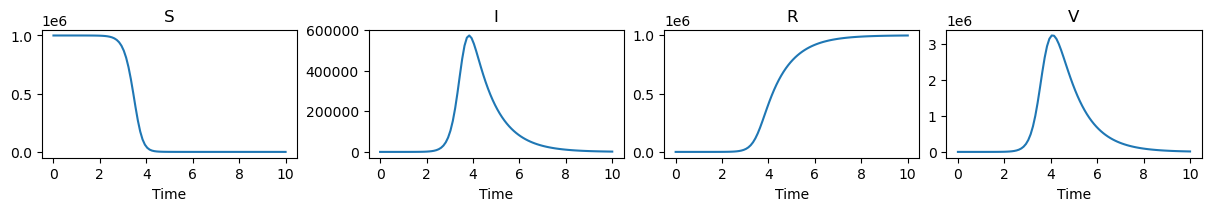

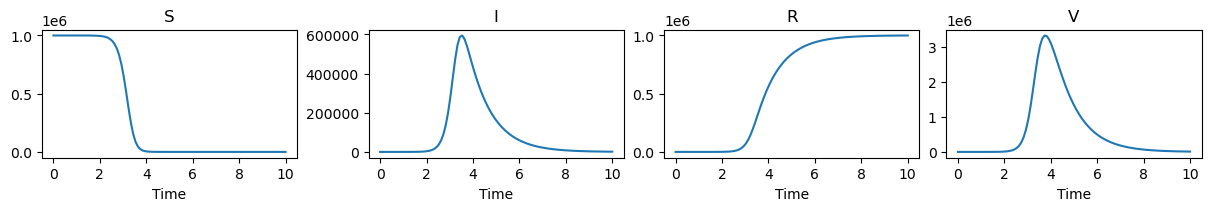

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

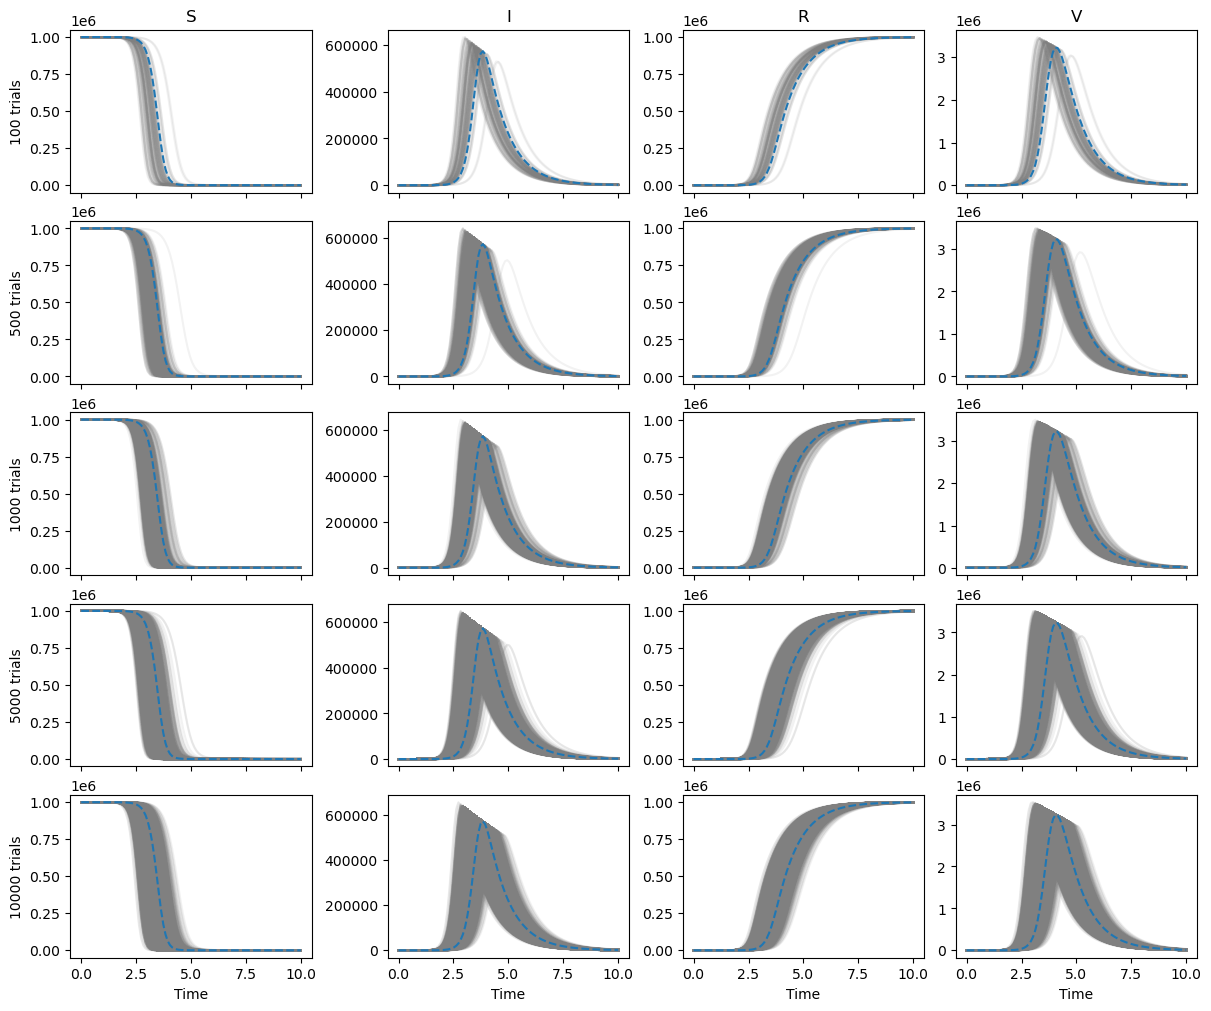

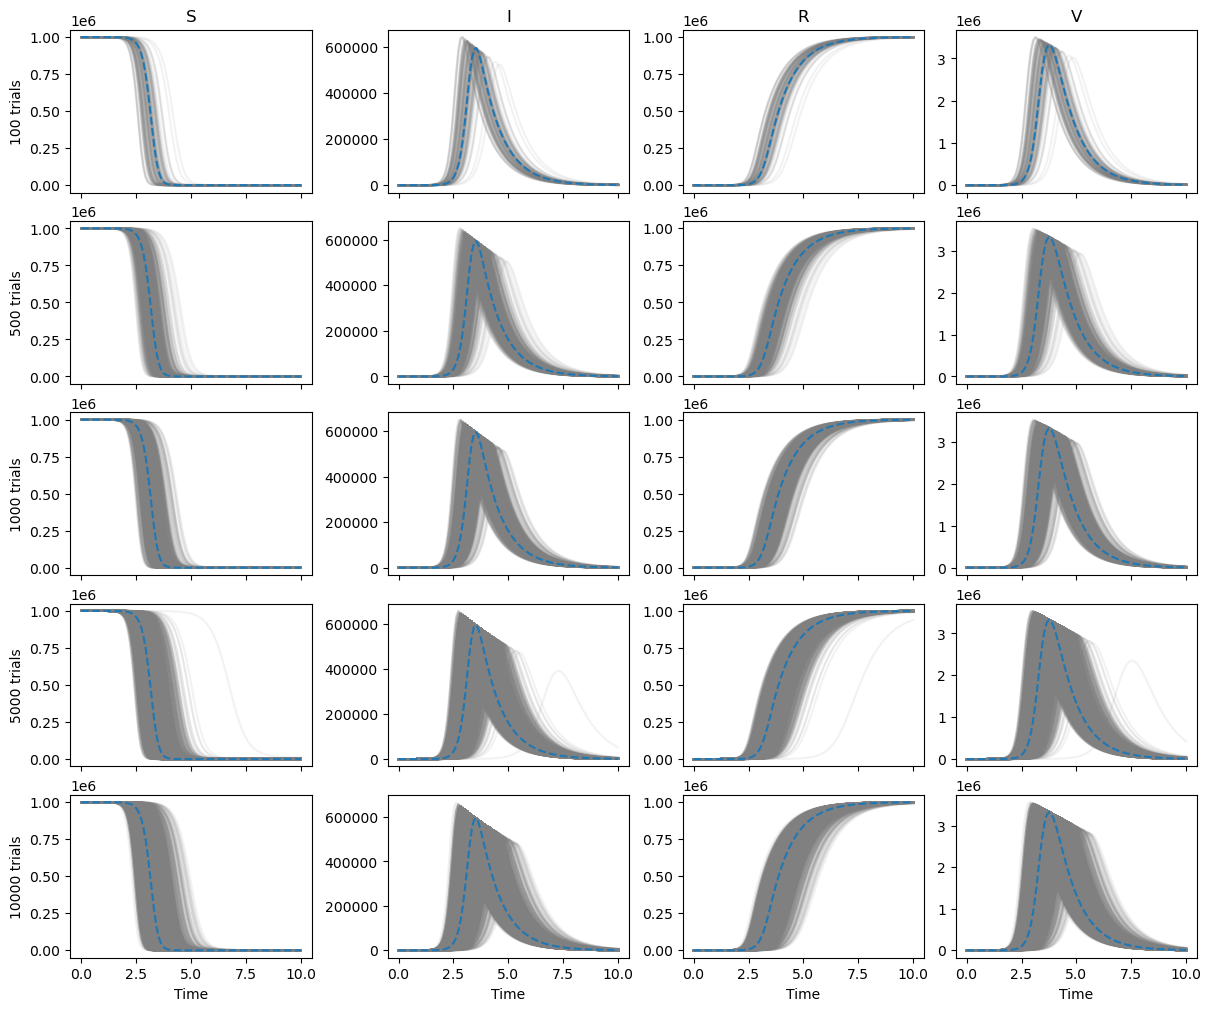

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

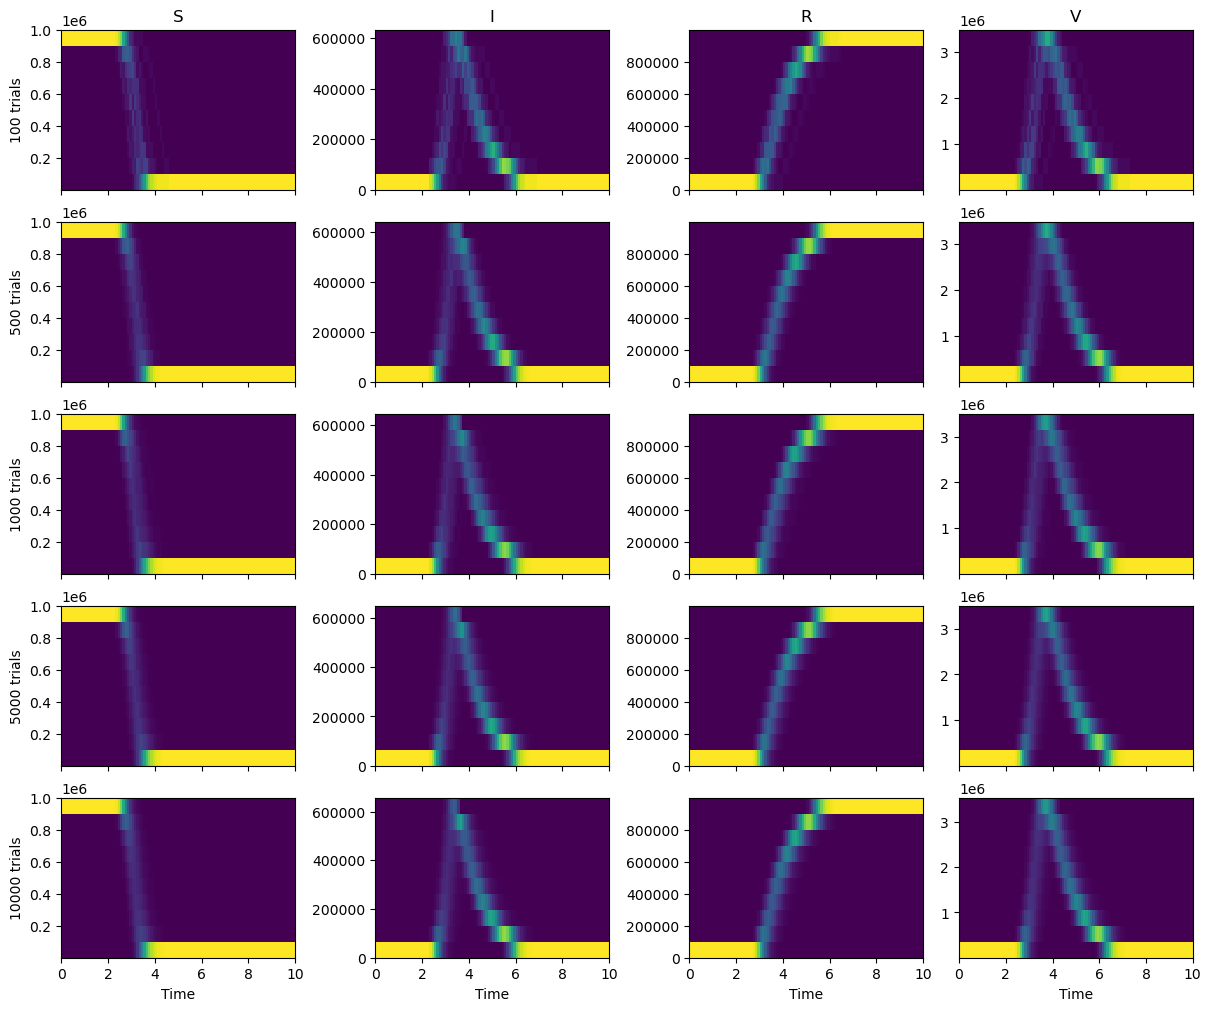

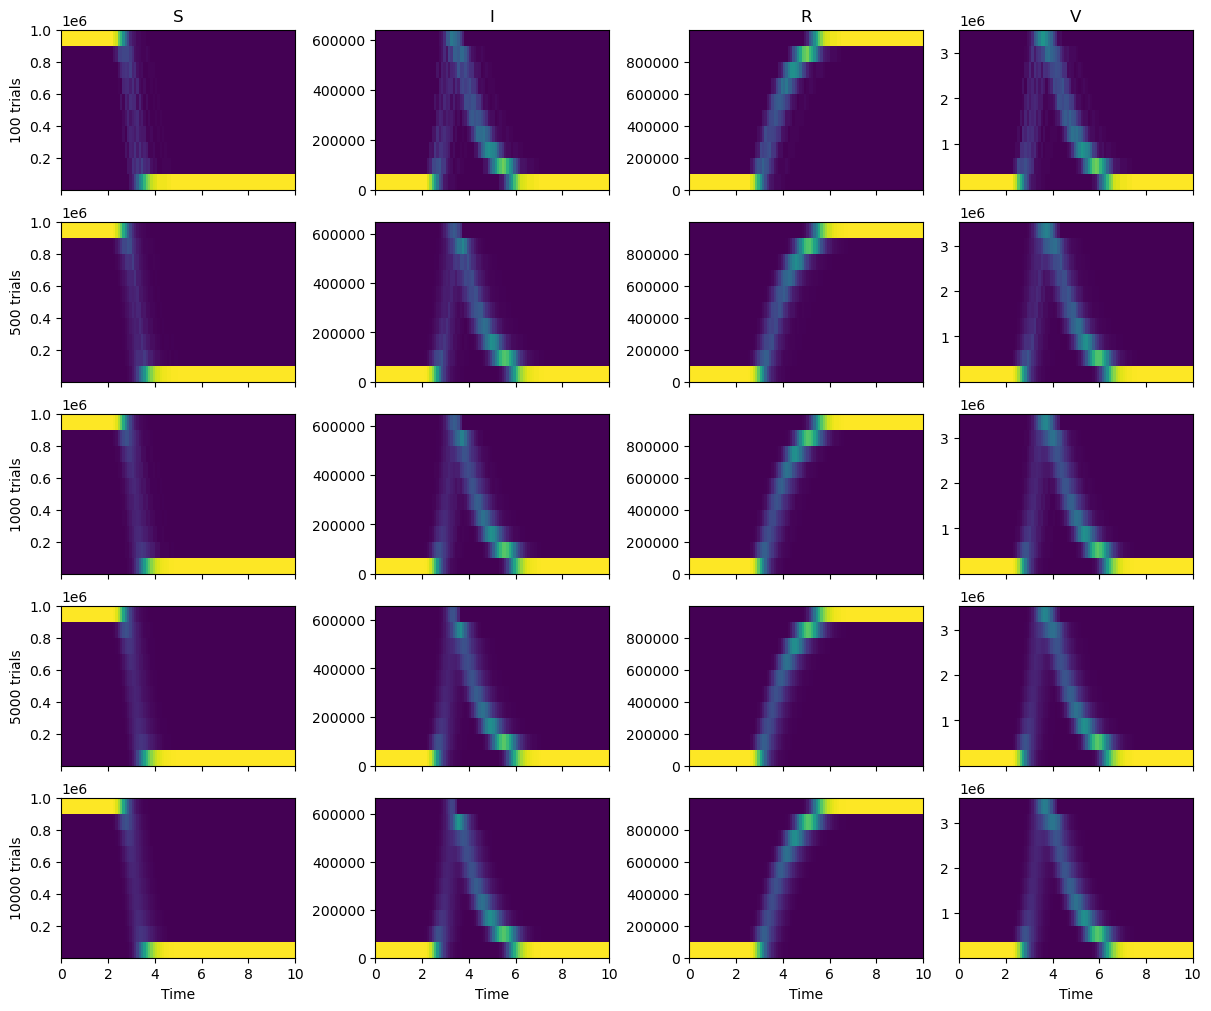

In [5]:
for test in tests:
    _ = test.plot_distributions()

c:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


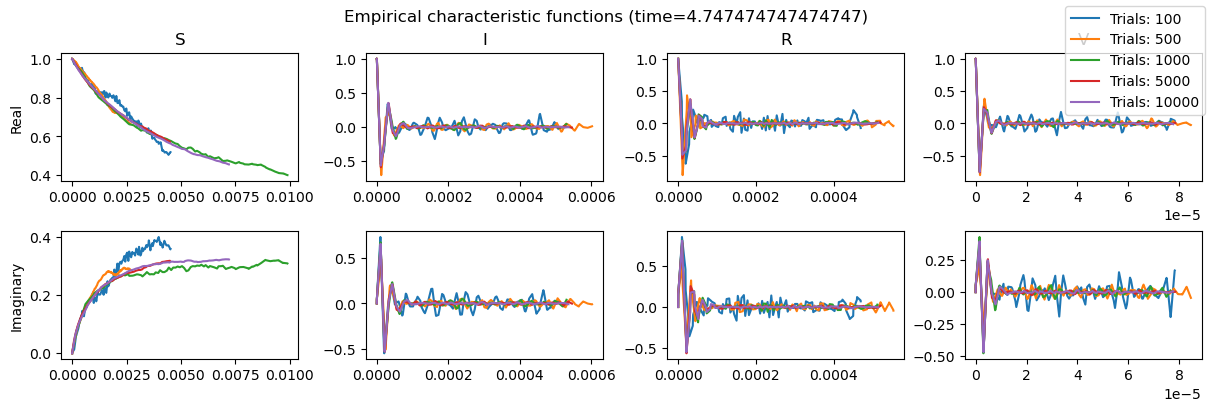

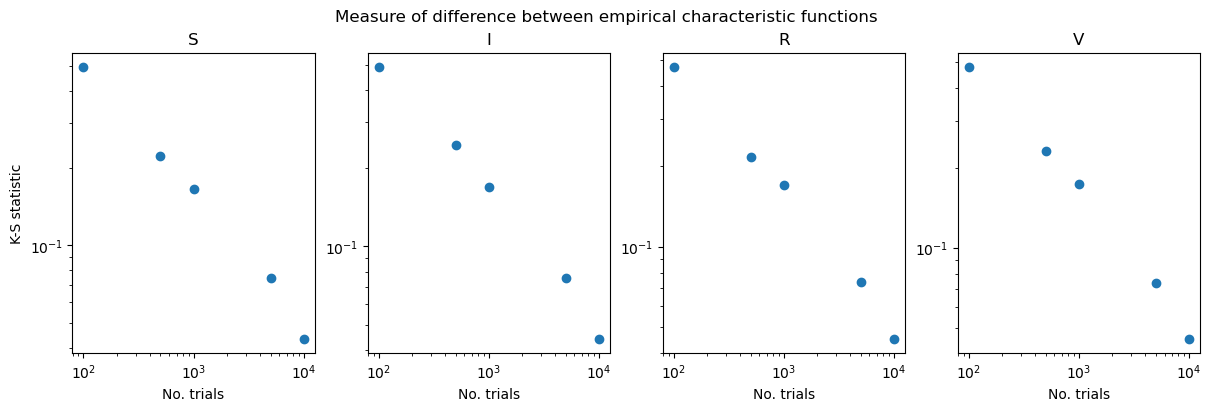

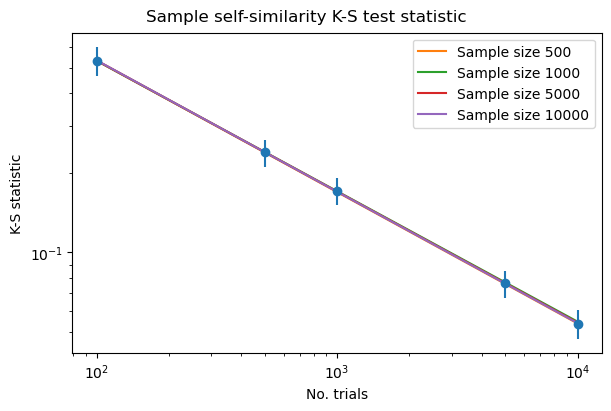

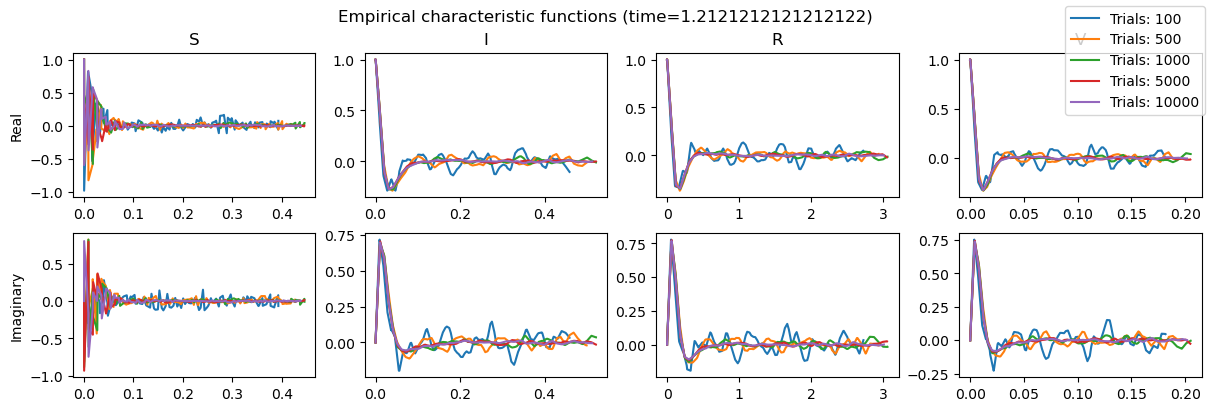

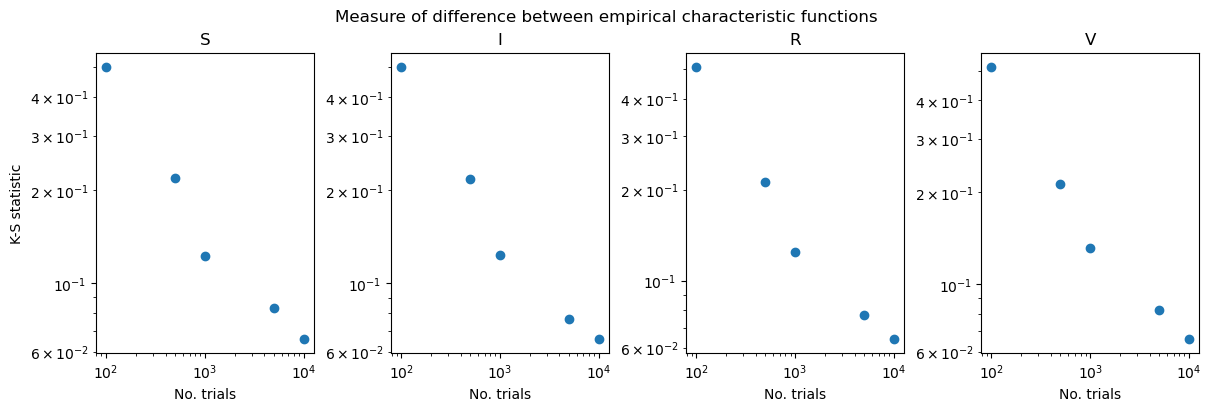

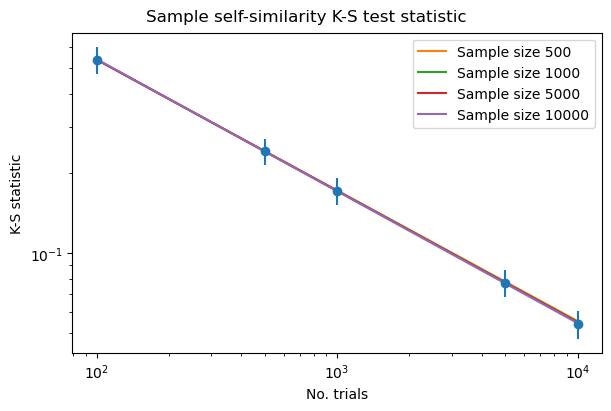

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

test1.save('proto_compare_6_test1.json')
test2.save('proto_compare_6_test2.json')

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

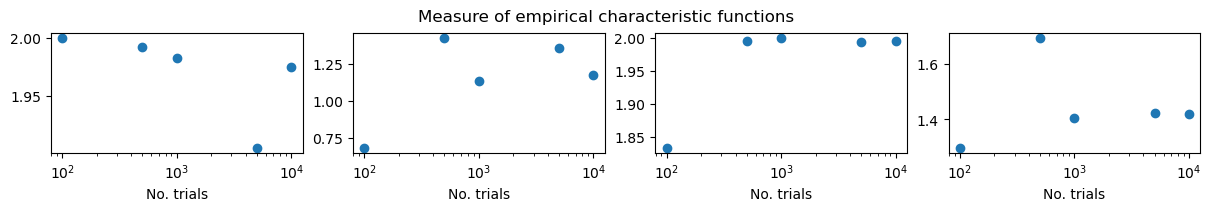

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in variance of model parameters. 

Output()

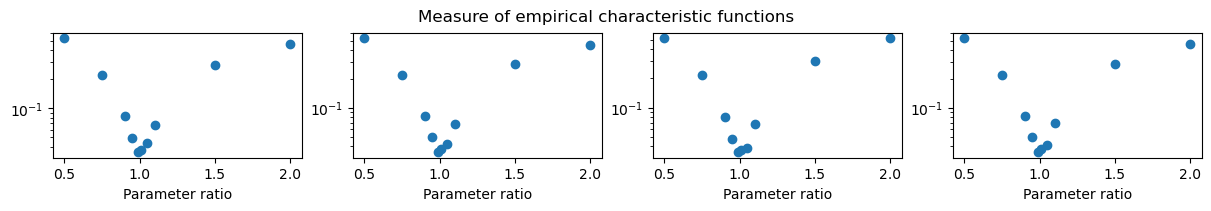

In [8]:
beta_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.01, 1.05, 1.1, 1.5, 2.0]
beta_test_kwargs = test_kwargs.copy()
beta_test_kwargs['trials'] = [test_kwargs['trials'][-1]]
beta_comp = list()

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for i, bf in enumerate(beta_fact):
    label.value = f'Factor: {bf}...'

    betatest_stdev = beta_stdev * bf
    test = Test(model=model_sir({'beta': ('norm', (beta_mean, betatest_stdev))}), stochastic=False, **test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test1.trials, test1.ecf_eval_info)
    beta_comp.append(sr.measure_ecf_diff_sets(test1.ecf, ecf2))

    test.save(f'proto_compare_6_fact_{i}.json')

out.clear_output()

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(beta_fact, [max([el[name] for el in diff[test1.trials[-1]]]) for diff in beta_comp])
    ax[i].set_xlabel('Parameter ratio')
    ax[i].set_yscale('log')
_ = fig.suptitle('Measure of empirical characteristic functions')